首先我们导入相关的库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from matplotlib import font_manager as fm
from sklearn.model_selection import StratifiedKFold

font_path = "C:/Windows/Fonts/simhei.ttf"
my_font = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = my_font.get_name()
plt.rcParams['axes.unicode_minus'] = False 
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")


在进行特征选择、特征提取和分类等操作之前，我们首先从基本数据分析开始。让我们看一下数据的特点。

In [2]:
# 读取数据
data = pd.read_csv('data.csv')
# 显示数据的前几行
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


输出数据的行数和列数，了解数据集的规模

In [3]:
#显示数据维度
print("数据维度:", data.shape)

数据维度: (569, 33)


检查并输出所有包含缺失值的列及其缺失数量，为后续数据清洗做准备

In [4]:
# 只显示有缺失值的列及其缺失数量
nan_cols = data.isnull().sum()
print("有缺失值的列：\n", nan_cols[nan_cols > 0])

有缺失值的列：
 Unnamed: 32    569
dtype: int64


从上述数据的显示和缺少值查看我们可以得出以下结论：
1.用户的id对于分类是没有任何帮助的，应当删去 
2.此数据中的 Unnamed: 32 列特征 全部都是缺失值，应当删去 
3.diagnosis 列表示结果是否为良性，是数据的标签

标签分布：
 diagnosis
0    357
1    212
Name: count, dtype: int64


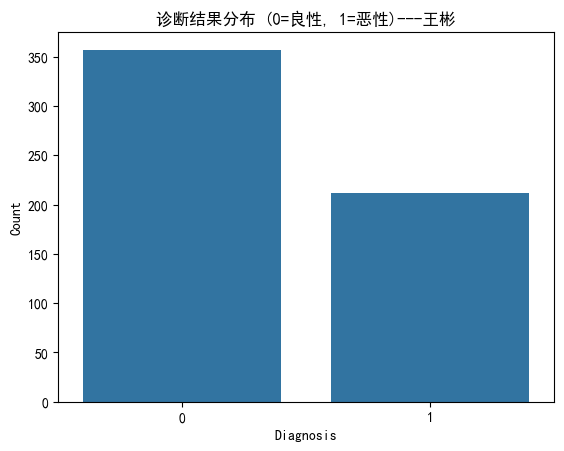

In [5]:
# 删除无用列
data = data.drop(columns=['Unnamed: 32', 'id'])
# 标签编码（B = 良性，M = 恶性）
label_encoder = LabelEncoder()
data['diagnosis'] = label_encoder.fit_transform(data['diagnosis'])  # M=1, B=0
print("标签分布：\n", data['diagnosis'].value_counts())


#  可视化诊断结果分布
sns.countplot(x='diagnosis', data=data)
plt.title('诊断结果分布 (0=良性, 1=恶性)---王彬')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()


下面我们来查看一下数据的分布：主要包括count：非空值的数量。
mean：数据的平均值。
std：数据的标准差，反映数据的离散程度。
min：数据的最小值。
25%：数据的第一个四分位数（25%的数据小于此值）。
50%（中位数）：数据的中位数（50%的数据小于此值）。
75%：数据的第三个四分位数（75%的数据小于此值）。
max：数据的最大值。这些统计信息可以帮助我们了解数据的中心趋势、离散程度，以及是否存在异常值等

In [6]:
# 数据分割
X = data.drop(columns=['diagnosis'])
y = data['diagnosis']
X.describe()#查看数据分布


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


通过上述数据的分布我们可以看出不同的特征的数值的取值范围存在较大的差异，这在机器学习建模时可能会导致某些特征对模型的影响被放大或缩小。因此，在后续的数据处理中，我们需要对特征进行标准化处理，使各特征具有相似的尺度，从而提升模型的表现和稳定性。

In [7]:

# 先划分训练集和测试集，并作数据标准化
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)


通过分别绘制不同特征区间（如前10个特征、中间10个特征、最后10个特征）的分布图，可以帮助我们直观地观察各特征在不同类别（良性与恶性）中的取值分布情况。这有助于：

1. 发现哪些特征对分类有较强的区分能力；
2. 识别特征之间的分布差异和异常值；
3. 为后续的特征选择和模型优化提供依据。

通过可视化分析，我们能够更好地理解数据特征与分类标签之间的关系，从而提升模型的解释性和准确性。

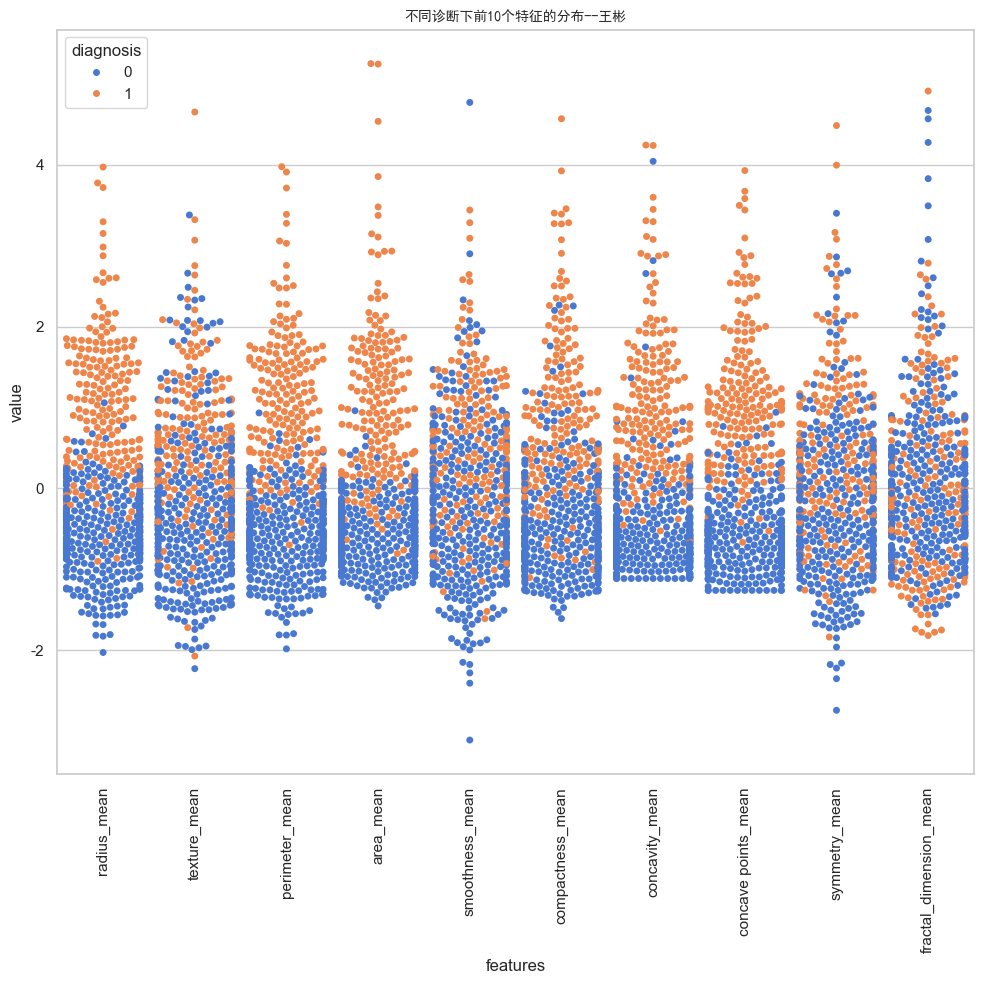

In [8]:
import time
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False    

# 构造用于绘图的数据
data_top10 = X_scaled[:, :10]  # 选择前10个特征
top10_feature_names = X.columns[:10]
data_top10_df = pd.DataFrame(data_top10, columns=top10_feature_names)
data_vis = pd.concat([y.reset_index(drop=True), data_top10_df], axis=1)

# 转换为适合 Seaborn 绘图的长格式
data_melt = pd.melt(data_vis, id_vars="diagnosis", var_name="features", value_name="value")

# 设置 Seaborn 风格
sns.set(style="whitegrid", palette="muted")

# 绘制 swarmplot
plt.figure(figsize=(10, 10))
tic = time.time()
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data_melt)
plt.title("不同诊断下前10个特征的分布--王彬", fontsize=16,fontproperties=my_font)  # 添加中文标题
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

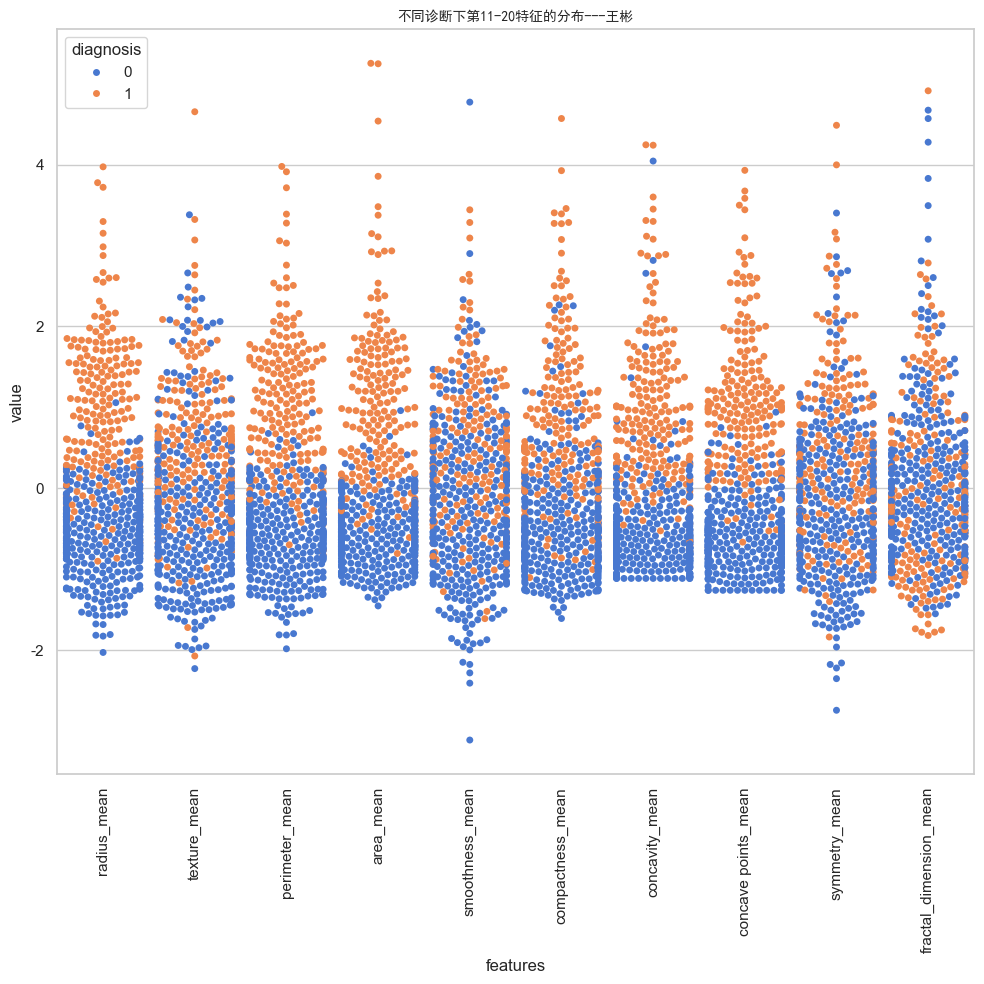

In [9]:
#  10-20个特征
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False   
data_10_20 = X_scaled[:, 10:20]
top10_20feature_names = X.columns[10:20]
data_10_20_df = pd.DataFrame(data_10_20, columns=top10_20feature_names)
data_vis = pd.concat([y.reset_index(drop=True), data_top10_df], axis=1)
#  转换为适合 seaborn 绘图的长格式
data_melt = pd.melt(data_vis, id_vars="diagnosis", var_name="features", value_name="value")
# 设置seaborn风格
sns.set(style="whitegrid", palette="muted")
# 绘制stripplot
plt.figure(figsize=(10, 10))
tic = time.time()
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data_melt)
plt.title("不同诊断下第11-20特征的分布---王彬", fontsize=16,fontproperties=my_font)  
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

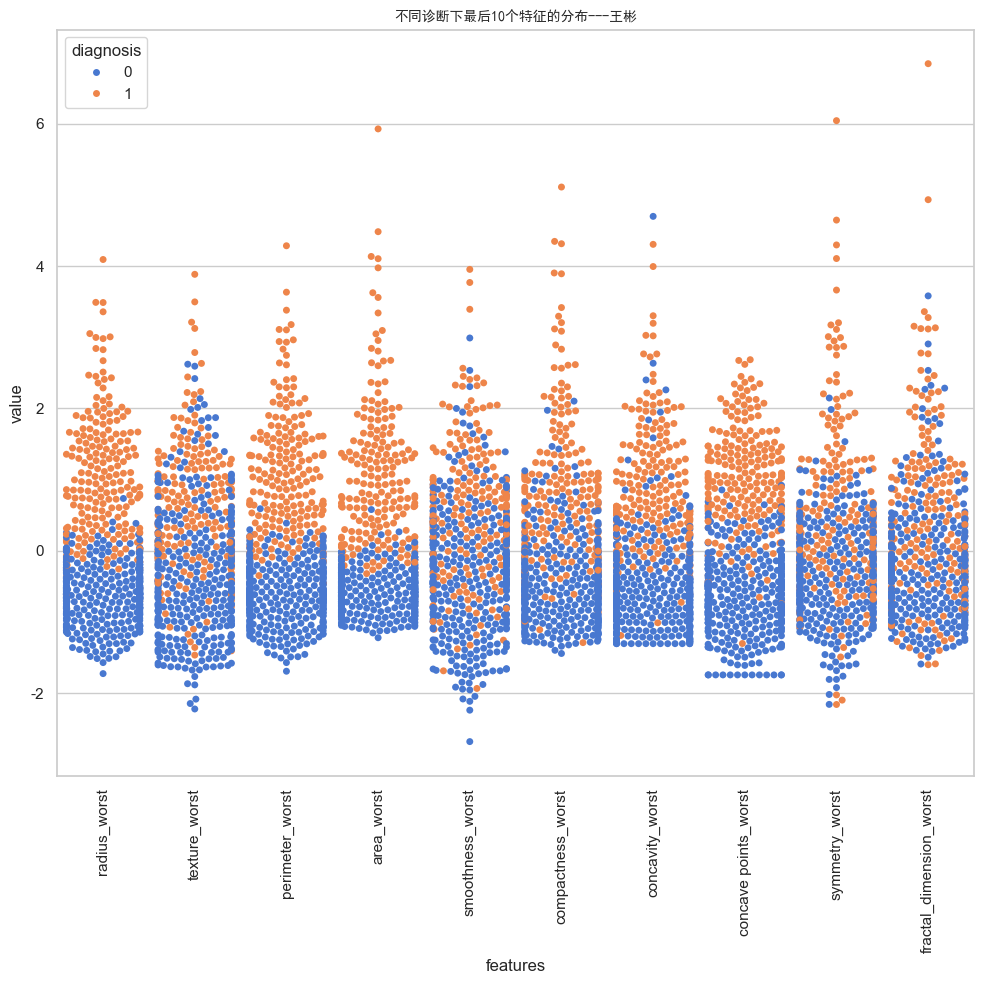

In [10]:
# 2.最后10个特征
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False    
data_20 = X_scaled[:, 20:]
top20_feature_names = X.columns[20:]
data_20_df = pd.DataFrame(data_20, columns=top20_feature_names)
data_vis = pd.concat([y.reset_index(drop=True), data_20_df], axis=1)
# 4. 转换为适合 seaborn 绘图的长格式
data_melt = pd.melt(data_vis, id_vars="diagnosis", var_name="features", value_name="value")
# 5. 设置seaborn风格
sns.set(style="whitegrid", palette="muted")
# 6. 绘制swarmplot
plt.figure(figsize=(10, 10))
tic = time.time()
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data_melt)
plt.title("不同诊断下最后10个特征的分布---王彬", fontsize=16,fontproperties=my_font)  
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



下面我们将通过热力图（Heatmap）来可视化各特征之间的相关性。热力图能够帮助我们直观地观察特征之间的相关关系，识别冗余特征和潜在的多重共线性问题，为后续的特征选择和模型优化提供依据。

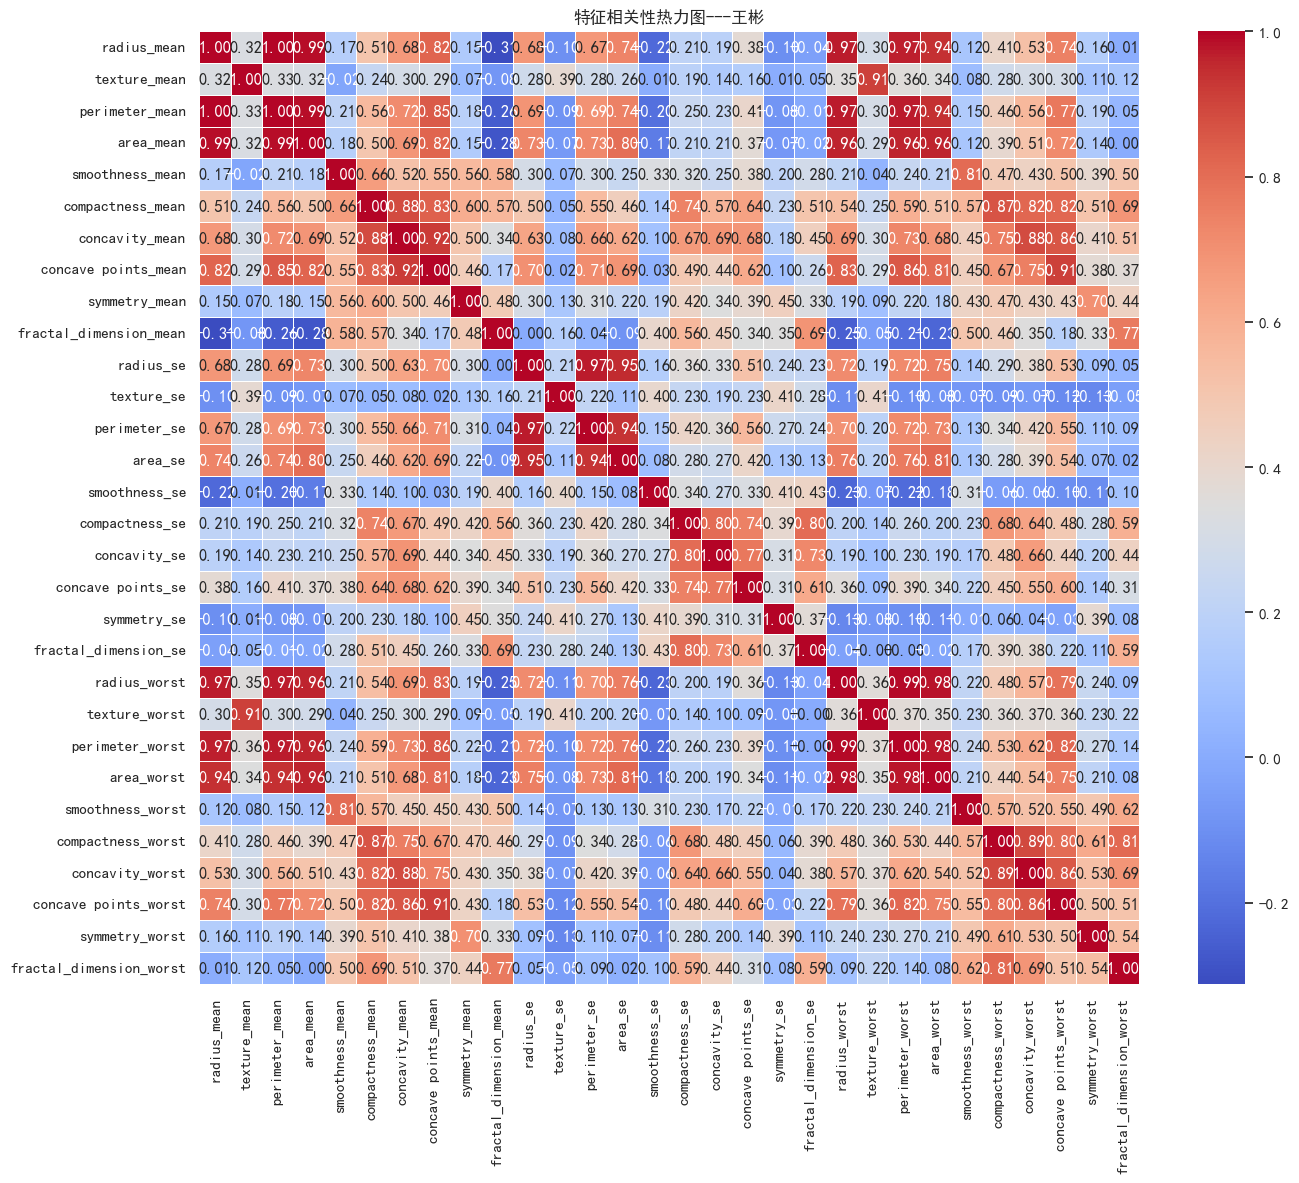

In [11]:

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
warnings.filterwarnings("ignore", category=UserWarning)
# 计算特征相关性矩阵
corr = X.corr()
# 绘制热力图
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('特征相关性热力图---王彬')
plt.tight_layout()
plt.show()

下面我们进行特征选择：用随机森林评估每个特征的重要性，并测试不同数量的特征对SVM模型准确率的影响。通过绘图直观展示特征数量与模型准确率的关系，自动选出最优特征数量和对应特征。

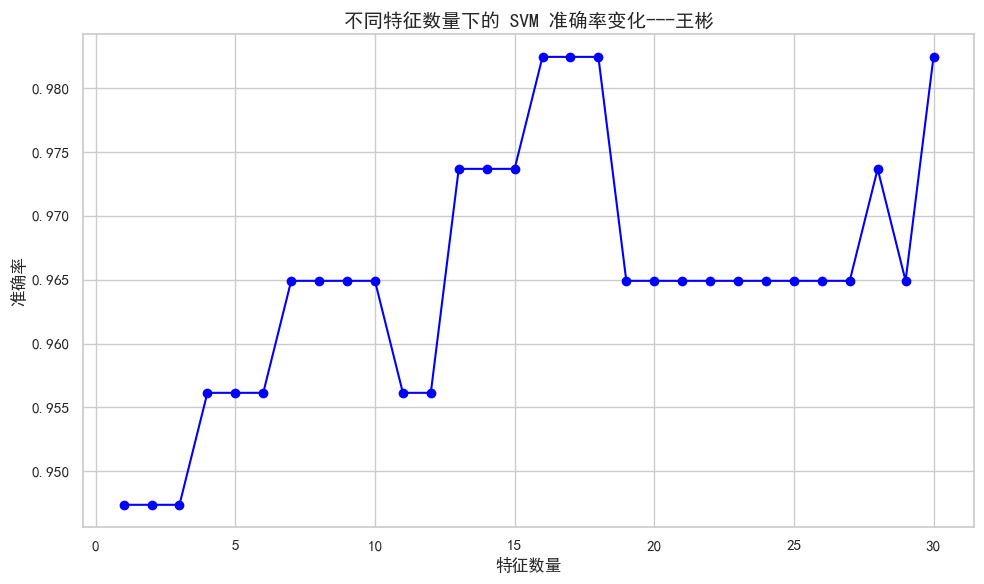


 最佳特征数量: 16，对应准确率: 0.9825

 最优特征及其重要性排序：

                 Feature  Importance
0             area_worst    0.139357
1   concave points_worst    0.132225
2    concave points_mean    0.107046
3           radius_worst    0.082848
4        perimeter_worst    0.080850
5         perimeter_mean    0.067990
6         concavity_mean    0.066917
7              area_mean    0.060462
8        concavity_worst    0.037339
9            radius_mean    0.034843
10               area_se    0.029553
11     compactness_worst    0.019864
12         texture_worst    0.017485
13          texture_mean    0.015225
14             radius_se    0.014264
15      smoothness_worst    0.012232


In [12]:
# 用随机森林提取特征重要性
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X, y)
importances = rf_temp.feature_importances_

feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

#  测试不同数量特征对 SVM 准确率的影响
max_features = len(feature_names)
accuracy_list = []


for n in range(1, max_features + 1):
    top_n_features = feature_importance_df['Feature'].iloc[:n].tolist()
    # 只选择前n个特征
    X_train_selected = X_train[top_n_features]
    X_test_selected = X_test[top_n_features]
    # 对选中的特征进行标准化
    scaler_temp = StandardScaler()
    X_train_selected_scaled = scaler_temp.fit_transform(X_train_selected)
    X_test_selected_scaled = scaler_temp.transform(X_test_selected)
    clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    clf.fit(X_train_selected_scaled, y_train)
    y_pred = clf.predict(X_test_selected_scaled)
    acc = accuracy_score(y_test, y_pred)
    accuracy_list.append(acc)

#  绘制特征数 vs 准确率 曲线
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_features + 1), accuracy_list, marker='o', color='blue')
plt.title("不同特征数量下的 SVM 准确率变化---王彬", fontsize=14)
plt.xlabel("特征数量")
plt.ylabel("准确率")
plt.grid(True)
plt.tight_layout()
plt.show()

#  找到最佳特征数量
best_n = np.argmax(accuracy_list) + 1
print(f"\n 最佳特征数量: {best_n}，对应准确率: {accuracy_list[best_n - 1]:.4f}\n")

#  输出最佳特征的排序与重要性
best_features_df = feature_importance_df.head(best_n)
print(" 最优特征及其重要性排序：\n")
print(best_features_df)



用筛选出的最佳特征训练SVM模型，并在测试集上评估模型性能，输出详细的分类报告和混淆矩阵。最后用5折交叉验证评估模型的泛化能力，输出每折准确率和平均准确率，全面衡量模型效果。


第 1 折交叉验证 - 分类报告：
              precision    recall  f1-score   support

       良性(B)   0.985714  0.971831  0.978723        71
       恶性(M)   0.954545  0.976744  0.965517        43

    accuracy                       0.973684       114
   macro avg   0.970130  0.974288  0.972120       114
weighted avg   0.973958  0.973684  0.973742       114

混淆矩阵：
[[69  2]
 [ 1 42]]

第 2 折交叉验证 - 分类报告：
              precision    recall  f1-score   support

       良性(B)   0.945946  0.985915  0.965517        71
       恶性(M)   0.975000  0.906977  0.939759        43

    accuracy                       0.956140       114
   macro avg   0.960473  0.946446  0.952638       114
weighted avg   0.956905  0.956140  0.955801       114

混淆矩阵：
[[70  1]
 [ 4 39]]

第 3 折交叉验证 - 分类报告：
              precision    recall  f1-score   support

       良性(B)   0.972973  1.000000  0.986301        72
       恶性(M)   1.000000  0.952381  0.975610        42

    accuracy                       0.982456       114
   macro avg   0.9864

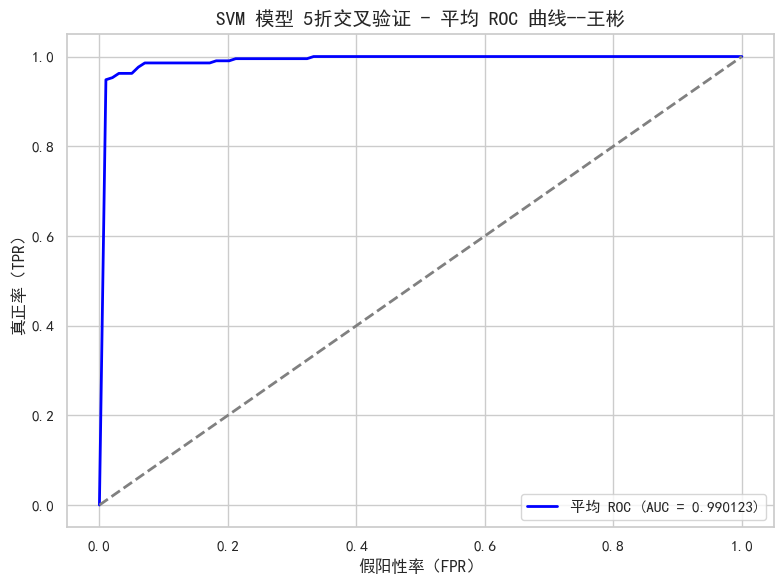

In [13]:

#  使用最佳特征构建 SVM 模型并评估
best_features = best_features_df['Feature'].tolist()
# 选择最佳特征的训练集和测试集（DataFrame）
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

# 对最佳特征进行标准化
scaler_best = StandardScaler()
X_train_best_scaled = scaler_best.fit_transform(X_train_best)
X_test_best_scaled = scaler_best.transform(X_test_best)

# 用全部数据的最佳特征做交叉验证
X_best = X[best_features]
X_best_scaled = scaler_best.fit_transform(X_best)

np.set_printoptions(precision=6, suppress=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

all_y_true = []
all_y_pred = []

plt.figure(figsize=(8, 6))

for i, (train_idx, test_idx) in enumerate(cv.split(X_best_scaled, y)):
    X_cv_train, X_cv_test = X_best_scaled[train_idx], X_best_scaled[test_idx]
    y_cv_train, y_cv_test = y[train_idx], y[test_idx]

    clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
    clf.fit(X_cv_train, y_cv_train)

    y_cv_pred = clf.predict(X_cv_test)
    y_cv_prob = clf.predict_proba(X_cv_test)[:, 1]

    all_y_true.extend(y_cv_test)
    all_y_pred.extend(y_cv_pred)

    print(f"\n第 {i+1} 折交叉验证 - 分类报告：")
    print(classification_report(y_cv_test, y_cv_pred, target_names=["良性(B)", "恶性(M)"], digits=6))

    cm = confusion_matrix(y_cv_test, y_cv_pred)
    print("混淆矩阵：")
    print(cm)

    fpr, tpr, _ = roc_curve(y_cv_test, y_cv_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

# 汇总整体结果
print("\n【整体交叉验证结果】")
print("总体分类报告：")
print(classification_report(all_y_true, all_y_pred, target_names=["良性(B)", "恶性(M)"], digits=6))

# 平均 ROC 曲线绘图
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'平均 ROC (AUC = {mean_auc:.6f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)

plt.title("SVM 模型 5折交叉验证 - 平均 ROC 曲线--王彬", fontsize=14)
plt.xlabel('假阳性率（FPR）')
plt.ylabel('真正率（TPR）')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
